<a href="https://colab.research.google.com/github/saguileran/MD-SCPI/blob/main/NoteBooks/Plots_MC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
#@title Github
%%capture

!rm -r /content/MD-SCPI
!git clone https://github.com/saguileran/MD-SCPI

import sys
!{sys.executable} -m pip install ipympl

In [2]:
#@title Existing temperatures
!ls "MD-SCPI/PDBs/MC/AS4/"

10000K	20000K	4800K	    600K	 box.pdb	 MR.mol2.gz
1200K	2400K	5000K	    9600K	 libela.sub
15000K	300K	5000K_long  AS4.mol2.gz  MR-AS4.mol2.gz


In [182]:
import gzip
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from google.colab import output
import numpy as np
import matplotlib as mpl
from scipy.stats import linregress
import matplotlib.cm as cm
from matplotlib import gridspec
import matplotlib.colors as mcolors

def ReadGz(path):
  file1 = gzip.open(path)
  a = file1.read()

  array, c = [], 0
  text = str(a).split()[11:]
  head = text[:14] # 20 

  if   'AS4' in path: index_init = 20
  elif 'STR' in path: index_init = 16
  elif 'COL' in path: index_init = 18

  for i in range(index_init,len(text)):
    c += 1
    if '\\n' in text[i]:
      text[i] = text[i].replace("\\n","")
      text[i] = text[i].replace("'","")
      words = [float(word) for word in text[i-c+1:i+1]]
      array.append(words) #text[i-c+1:i+1])
      c = 0

  array = np.array(array)
  data = pd.DataFrame({head[i]:array[:,i] for i in range(len(head))})
  return data

%matplotlib ipympl
output.enable_custom_widget_manager()

In [4]:
temperatures = ['300K', '600K', '1200K', '2400K', '4800K', '5000K']
high_temperatures = ['9600K', '10000K', '15000K', '20000K']

colors = ['gray', 'violet', 'red', 'green', 'orange', 'blue', 'orchid']
several_colors = sorted(mcolors.CSS4_COLORS, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
several_colors = [color for color in several_colors if (color!='white' and color!='snow')]

root_path = 'MD-SCPI/PDBs/MC/'

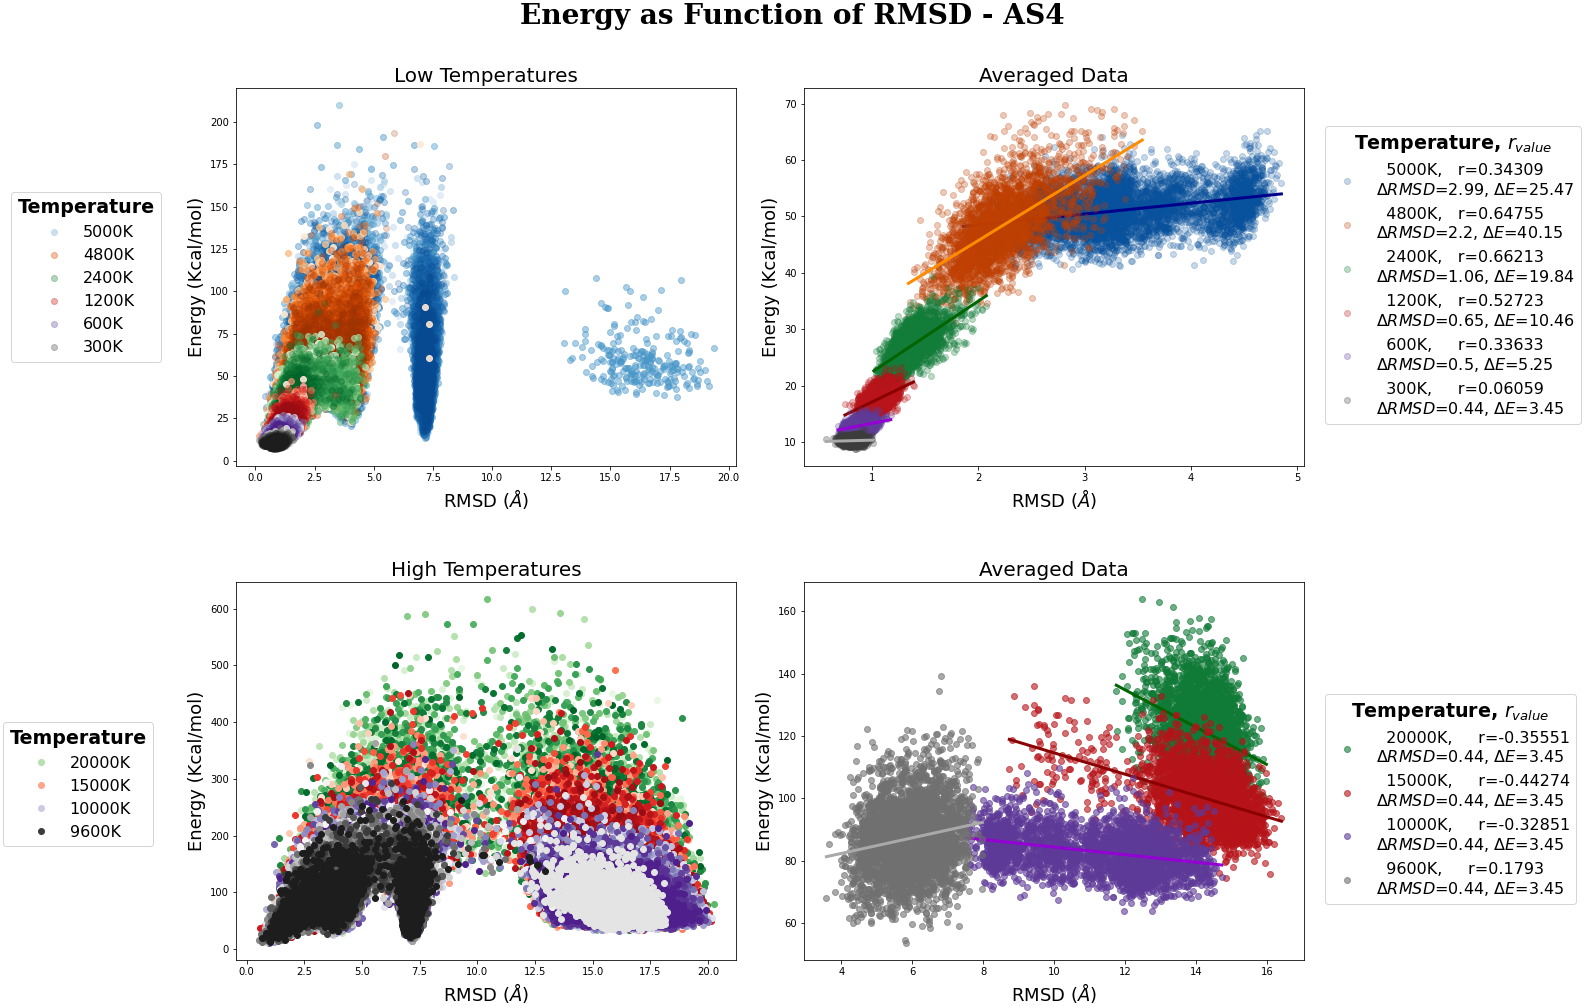

In [ ]:
def Plot_Energy(ligand, save=True):
  parameters, high_parameters = pd.DataFrame(), pd.DataFrame()
  path = root_path+'/'+ligand+'/'

  plt.close()
  fig = plt.figure(layout="constrained", figsize=(22,14)) # tight_layout=True
  gs = gridspec.GridSpec(2, 2, hspace=0.1, figure=fig)

  N_plot = 5    # is used to plot, number of plots is N_samples%N_plot 
  #ax = fig.add_subplot(gs[2, :])
  axs = np.array([[fig.add_subplot(gs[0,0]),fig.add_subplot(gs[0,1])],  [fig.add_subplot(gs[1,0]),fig.add_subplot(gs[1,1])]])

  c=0
  for i in range(len(temperatures)-1,-1,-1): #list(reversed((temperatures))):
    rmsd, energy = [], []
    gz_files = [f for f in listdir(path+temperatures[i]) if isfile(join(path+temperatures[i], f)) and (('mol2' not in f) and ('.gitignore' not in f))]
    
    N = len(gz_files)
    unit, unit2 = np.linspace(0.1, 0.9, N), np.linspace(0.9, 0.2, N)
    Colors = [cm.Greys(unit), cm.Purples(unit), cm.Reds(unit), cm.Greens(unit), cm.Oranges(unit), cm.Blues(unit), cm.RdPu(unit)]

    for j in range(len(temperatures)):
      for k in range(N):
        Colors[j][k][-1]=unit2[k]

    for j in range(len(gz_files)):
      data = ReadGz(path+temperatures[i]+'/'+gz_files[j])
      rmsd.append(data['RMSD']); energy.append(data['Energy'])
      if j==7:   axs[0,0].plot(data['RMSD'], data['Energy'], 'o', label=temperatures[i], color=Colors[i][j]) #colors[i], alpha=1-0.15*i)
      else:      axs[0,0].plot(data['RMSD'], data['Energy'], 'o',  color=Colors[i][j])

      rmsd_array = np.linspace(min(data['RMSD']), max(data['RMSD']), 1000)
      slope, intercept, r_value, p_value, std_err = linregress(data['RMSD'], data['Energy'])
      # axs[0].plot(rmsd_array, slope*rmsd_array+intercept, color='dark'+colors[i], lw=3)

      value = pd.DataFrame({'temperature':temperatures[i],'slope':slope, 'intercept':intercept, 'r_value':r_value, 
                          'p_value':p_value, 'std_err':std_err, #'deltaE':float(max(energy)-min(energy)), 'deltaRMSD':float(max(rmsd)-min(rmsd)),
                          'E_mean':np.mean(energy), 'RMSD_mean':np.mean(rmsd)}, index=[c])
      parameters = pd.concat([parameters, value], ignore_index=True)
      c += 1
    
      # -------- remove repeated legend labels -------------
      # handles, labels = plt.gca().get_legend_handles_labels()
      # by_label = dict(zip(labels, handles))
      # plt.legend(by_label.values(), by_label.keys())
    
    # -------- average ------------------
    rmsd = np.average(np.array(rmsd), axis=0); energy = np.average(np.array(energy), axis=0)
    slope, intercept, r_value, p_value, std_err = linregress(rmsd, energy)
    rmsd_array = np.linspace(min(rmsd), max(rmsd), 1000)
    if len(temperatures[i]) == 4:
            label = '  '+temperatures[i]+',     r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
    else:    label = '  '+temperatures[i]+',   r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
    axs[0,1].plot(rmsd, energy, 'o', label=label, color=Colors[i][j-1])#colors[i], alpha=0.5)
    axs[0,1].plot(rmsd_array, slope*rmsd_array+intercept, color='dark'+colors[i], lw=3)
    
  #######################################################################################
  # --------------------------------- high temperatures --------------------------------------------
  c=0
  for i in range(len(high_temperatures)-1,-1,-1): #list(reversed((temperatures))):
    high_rmsd, high_energy = [], []
    gz_files = [f for f in listdir(path+high_temperatures[i]) if isfile(join(path+high_temperatures[i], f)) and (('mol2' not in f) and ('gitignore' not in f))]

    N_high = len(gz_files)
    unit_high, unit2_high = np.linspace(0.1, 0.9, N_high), np.linspace(0.9, 0.2, N_high)
    Colors_high = [cm.Greys(unit_high), cm.Purples(unit_high), cm.Reds(unit_high), cm.Greens(unit_high), cm.Oranges(unit_high), cm.Blues(unit_high)]

    for j in range(len(gz_files)):
      data = ReadGz(path+high_temperatures[i]+'/'+gz_files[j])
      high_rmsd.append(data['RMSD']); high_energy.append(data['Energy'])
      if j==8: axs[1,0].plot(data['RMSD'], data['Energy'], 'o', label=high_temperatures[i], color=Colors_high[i][j])
      else:     axs[1,0].plot(data['RMSD'], data['Energy'], 'o', color=Colors_high[i][j])

      rmsd_array = np.linspace(min(data['RMSD']), max(data['RMSD']), 1000)
      slope, intercept, r_value, p_value, std_err = linregress(data['RMSD'], data['Energy'])

      value = pd.DataFrame({'temperature':temperatures[i],'slope':slope, 'intercept':intercept, 'r_value':r_value, 
                          'p_value':p_value, 'std_err':std_err, #'deltaE':float(max(energy)-min(energy)), 'deltaRMSD':float(max(rmsd)-min(rmsd)),
                          'E_mean':np.mean(energy), 'RMSD_mean':np.mean(rmsd)}, index=[c])
      high_parameters = pd.concat([high_parameters, value], ignore_index=True)

      c += 1
    # -------- average ------------------
    high_rmsd = np.average(np.array(high_rmsd), axis=0); high_energy = np.average(np.array(high_energy), axis=0)
    slope, intercept, r_value, p_value, std_err = linregress(high_rmsd, high_energy)
    rmsd_array = np.linspace(min(high_rmsd), max(high_rmsd), 1000)
    #if len(temperatures[i]) == 4:
    label = '  '+high_temperatures[i]+',     r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
    #else:    label = '  '+high_temperatures[i]+',   r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
    axs[1,1].plot(high_rmsd, high_energy, 'o', label=label, color=Colors_high[i][j-3], alpha=0.6)#colors[i], alpha=0.5)
    axs[1,1].plot(rmsd_array, slope*rmsd_array+intercept, color='dark'+colors[i], lw=3)

  # ----------- legends, labels and titles for each axis ----------------
  axs[0,0].set_ylabel('Energy (Kcal/mol)', fontsize='18'); axs[0,0].set_xlabel('RMSD ($\AA$)', fontsize='18'); 
  axs[0,0].legend(title='Temperature', bbox_to_anchor=(-.15, .725), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'}, borderaxespad=0.)
  axs[0,0].set_title('Low Temperatures', fontsize='20', fontweight='normal')
  #plt.ylim((0, 100)); plt.xlim((0, 10))

  #axs[1].sharex(axs[0,0])
  axs[0,1].set_xlabel('RMSD ($\AA$)', fontsize='18'); axs[0,1].set_ylabel('Energy (Kcal/mol)', fontsize='18')
  axs[0,1].legend(title='Temperature, $r_{value}$', bbox_to_anchor=(1.025, 0.92), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'})
  axs[0,1].set_title('Averaged Data', fontsize='20', fontweight='normal')

  axs[1,0].set_xlabel('RMSD ($\AA$)', fontsize='18'); axs[1,0].set_ylabel('Energy (Kcal/mol)', fontsize='18')
  axs[1,0].legend(title='Temperature', bbox_to_anchor=(-.15, .65), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'})
  axs[1,0].set_title('High Temperatures', fontsize='20', fontweight='normal')

  axs[1,1].set_xlabel('RMSD ($\AA$)', fontsize='18'); axs[1,1].set_ylabel('Energy (Kcal/mol)', fontsize='18')
  axs[1,1].legend(title='Temperature, $r_{value}$', bbox_to_anchor=(1.025, 0.725), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'})
  axs[1,1].set_title('Averaged Data', fontsize='20', fontweight='normal')

  plt.suptitle('Energy as Function of RMSD - {}\n'.format(ligand), fontsize='28', fontweight='bold', x=0.5,  fontfamily='serif') #MC Simulation with LiBELa \n
  if save is True: fig.savefig("./MC_energies.png", transparent=True)#, bbox_inches='tight')

  return fig, parameters, high_parameters

fig, parameters, high_parameters =  Plot_Energy('AS4')

In [ ]:
parameters

temperature      slope  intercept   r_value        p_value   std_err  \
0        5000K   1.788622  42.783045  0.206626   7.366316e-59  0.109360   
1        5000K   2.248153  41.988231  0.287192  2.748592e-114  0.096818   
2        5000K  13.354350  20.080034  0.647533   0.000000e+00  0.202924   
3        5000K   3.017963  41.739267  0.319904  7.790823e-143  0.115411   
4        5000K   3.025988  40.476541  0.337725  5.654550e-160  0.108894   
..         ...        ...        ...       ...            ...       ...   
76        300K   1.149966   9.294271  0.140234   1.201294e-14  0.148287   
77        300K   0.778827   9.537000  0.095860   1.437561e-07  0.147701   
78        300K   0.798113   9.544075  0.101472   2.548883e-08  0.142908   
79        300K   0.577047   9.785477  0.071372   9.131331e-05  0.147284   
80        300K   0.631838   9.719187  0.078690   1.596472e-05  0.146191   

       E_mean  RMSD_mean  
0   53.339358   5.901925  
1   52.361659   5.040618  
2   51.289782   4.085918  
3   51.408020   3.894756  
4   51.268235   3.792116  
..        ...        ...  
76  10.256802   0.818428  
77  10.245395   0.818894  
78  10.239364   0.818817  
79  10.240898   0.817891  
80  10.240653   0.818284  

[81 rows x 8 columns]

In [ ]:
high_parameters

temperature     slope   intercept   r_value       p_value   std_err  \
0         2400K -6.401936  215.849036 -0.351914  3.515288e-88  0.310992   
1         2400K -5.549712  200.805315 -0.364532  6.006536e-95  0.258915   
2         2400K -5.459999  200.797666 -0.368306  4.948296e-97  0.251717   
3         2400K -7.370601  229.513351 -0.346237  3.098510e-85  0.364741   
4         2400K -5.052035  191.523333 -0.335876  5.140903e-80  0.258749   
..          ...       ...         ...       ...           ...       ...   
98         300K  3.637557   68.067144  0.220551  2.260257e-34  0.293803   
99         300K  3.407254   70.196661  0.202115  5.035569e-29  0.301531   
100        300K  2.583898   72.754577  0.153446  2.883791e-17  0.303899   
101        300K  3.584968   71.198456  0.202779  3.298446e-29  0.316176   
102        300K  3.483445   69.269940  0.209201  5.084069e-31  0.297380   

        E_mean  RMSD_mean  
0    10.240653   0.818284  
1    10.240653   0.818284  
2    10.240653   0.818284  
3    10.240653   0.818284  
4    10.240653   0.818284  
..         ...        ...  
98   10.240653   0.818284  
99   10.240653   0.818284  
100  10.240653   0.818284  
101  10.240653   0.818284  
102  10.240653   0.818284  

[103 rows x 8 columns]

In [198]:
%%time 

def BindingCounter(data_MC):
  temperatures = data_MC[data_MC['temperature'].duplicated()==False]['temperature'].values

  total = pd.DataFrame()
  c = 0
  for temp in temperatures:
    total_binding   = data_MC[data_MC['temperature'] == temp]['binding'].sum()
    total_unbinding = data_MC[data_MC['temperature'] == temp]['unbinding'].sum()

    total = pd.concat([total, pd.DataFrame({'ligand':str(data_MC.loc[0]['ligand']),'temperature':temp, 'binding':total_binding, 'unbinding':total_unbinding}, index=[c])], ignore_index=True)
  return total

def Roots(data, threshold):
  roots, types = [], []
  root1 = np.where(np.diff(np.sign(data['RMSD']-threshold)))[0]
  for r in root1:
    if data.iloc[r]['RMSD'] > threshold:      selected = r
    elif data.iloc[r+1]['RMSD'] > threshold:  selected = r+1
    else:                                     selected = r-1 
    
    index = np.arange(selected-5, selected+5, 1)
    over  = np.where(data.iloc[index]['RMSD'] > threshold)[0]
    lower = np.where(data.iloc[index]['RMSD'] < threshold)[0]
    if len(over)>3 and len(lower)>3:  
      roots.append(selected)
      next = np.where(data.iloc[np.arange(selected,selected+5,1)]['RMSD'] > threshold)[0]
      if len(next)>2:   tp = 'binding'
      elif len(next)<3: tp = 'unbinding'
      else:             tp = ''
      types.append(str(tp))

  roots = np.array(roots)
  heights = data.iloc[roots]['RMSD'].values
  #heights = thresholds[1]*np.ones_like(root1)
  
  return roots, heights, types

def Plot_RMSD(ligand, temperatures, N_plot=6, save=True, bins=100, bins_cum=50, thresholds=[6,11]):
  plt.close()
  fig = plt.figure(figsize=(18,6*len(temperatures)), layout="constrained")
  gs0 = gridspec.GridSpec(len(temperatures), 1, figure=fig, hspace=0.3)

  path = root_path+'/'+ligand+'/'
  all_data = pd.DataFrame()
  counter, axs = 0, []
  selected = np.linspace(0,30,1)

  for i in range(len(temperatures)):
    c = 0
    # if len(temperatures)==1: 
    #   gs = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs0)
    # else:
    gs = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs0[i,0], wspace=0.025)
    ax_main = plt.subplot(gs[0:3, :3])
    axs.append(ax_main)
    ax_yDist = plt.subplot(gs[:1, 3],sharey=ax_main)
    ax_main.grid(True); ax_yDist.grid(axis='y')

    gz_files = [f for f in listdir(path+temperatures[i]) if isfile(join(path+temperatures[i], f)) and (('mol2' not in f) and ('.gitignore' not in f))]
    for j in range(len(gz_files)):
      data = ReadGz(path+temperatures[i]+'/'+gz_files[j])
      root, heights, types = Roots(data, thresholds[1])
      
      dt = pd.DataFrame({'ligand':ligand, 'temperature':temperatures[i], 'sample':gz_files[j].split('_')[1], 'j':j, 'index':[root], 'type':[types], 
                         'heights':[heights], 'binding':types.count('binding'), 'unbinding':types.count('unbinding')}, index=[counter]) 
      all_data = pd.concat([all_data, dt], ignore_index=True)
      
      if j%N_plot==0: 
        
        
        ax_main.plot(1+data.index, data['RMSD'], '-', label=gz_files[j].split('_')[1], alpha=0.75, ms=3, color=several_colors[c])

        ax_yCumDist = ax_yDist.twiny()
        ax_yCumDist.hist(data['RMSD'],bins=bins_cum,cumulative=False,histtype='step',density=True,align='mid',orientation='horizontal', lw=1, color=several_colors[c])#, alpha=1)
        
        ax_yCumDist.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)
        ax_yDist.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)

        ax_main.plot(root+1, heights, 'x', alpha=1, ms=12, color=several_colors[c])

      counter += 1                                      # index dataframe
      c       += len(several_colors)//len(gz_files)-1   # color

    # ------------------------------------------ thresholds ------------------------------------------
    ax_main.plot(thresholds[0]*np.ones_like(data['RMSD']), '--b');    ax_main.plot(thresholds[1]*np.ones_like(data['RMSD']), '--k')
    ax_yCumDist.plot(thresholds[0]*np.ones_like(data['RMSD']), '--b');    ax_yCumDist.plot(thresholds[1]*np.ones_like(data['RMSD']), '--k')
    
    ax_main.set_title(temperatures[i], fontsize='20', fontweight='normal', x=0.7, y=1.02)
    ax_main.set_ylabel('RMSD ($\AA$)', fontsize='18'); ax_main.set_xlabel(r'MC step # ($\times 10^4$)', fontsize='18')
    ax_main.legend(title='Sample #', bbox_to_anchor=(-0.07, 0.85), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'})
    #ax_main.set_xlim((0, 3000));     ax_main.set_ylim((0, 8.5))
    #if i!=0: ax_main.sharex(axs[0])

  total = BindingCounter(all_data)
  [axs[i].sharex(axs[0]) for i in range(len(axs)) if i!=0];
  plt.suptitle('RMSD - {} \n'.format(ligand), fontsize='28', fontweight='bold', x=0.5,  fontfamily='serif')
  if save is True: fig.savefig("./MC_RMSD.png", transparent=True)#, bbox_inches='tight')

  return fig, all_data, total

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 13.6 µs


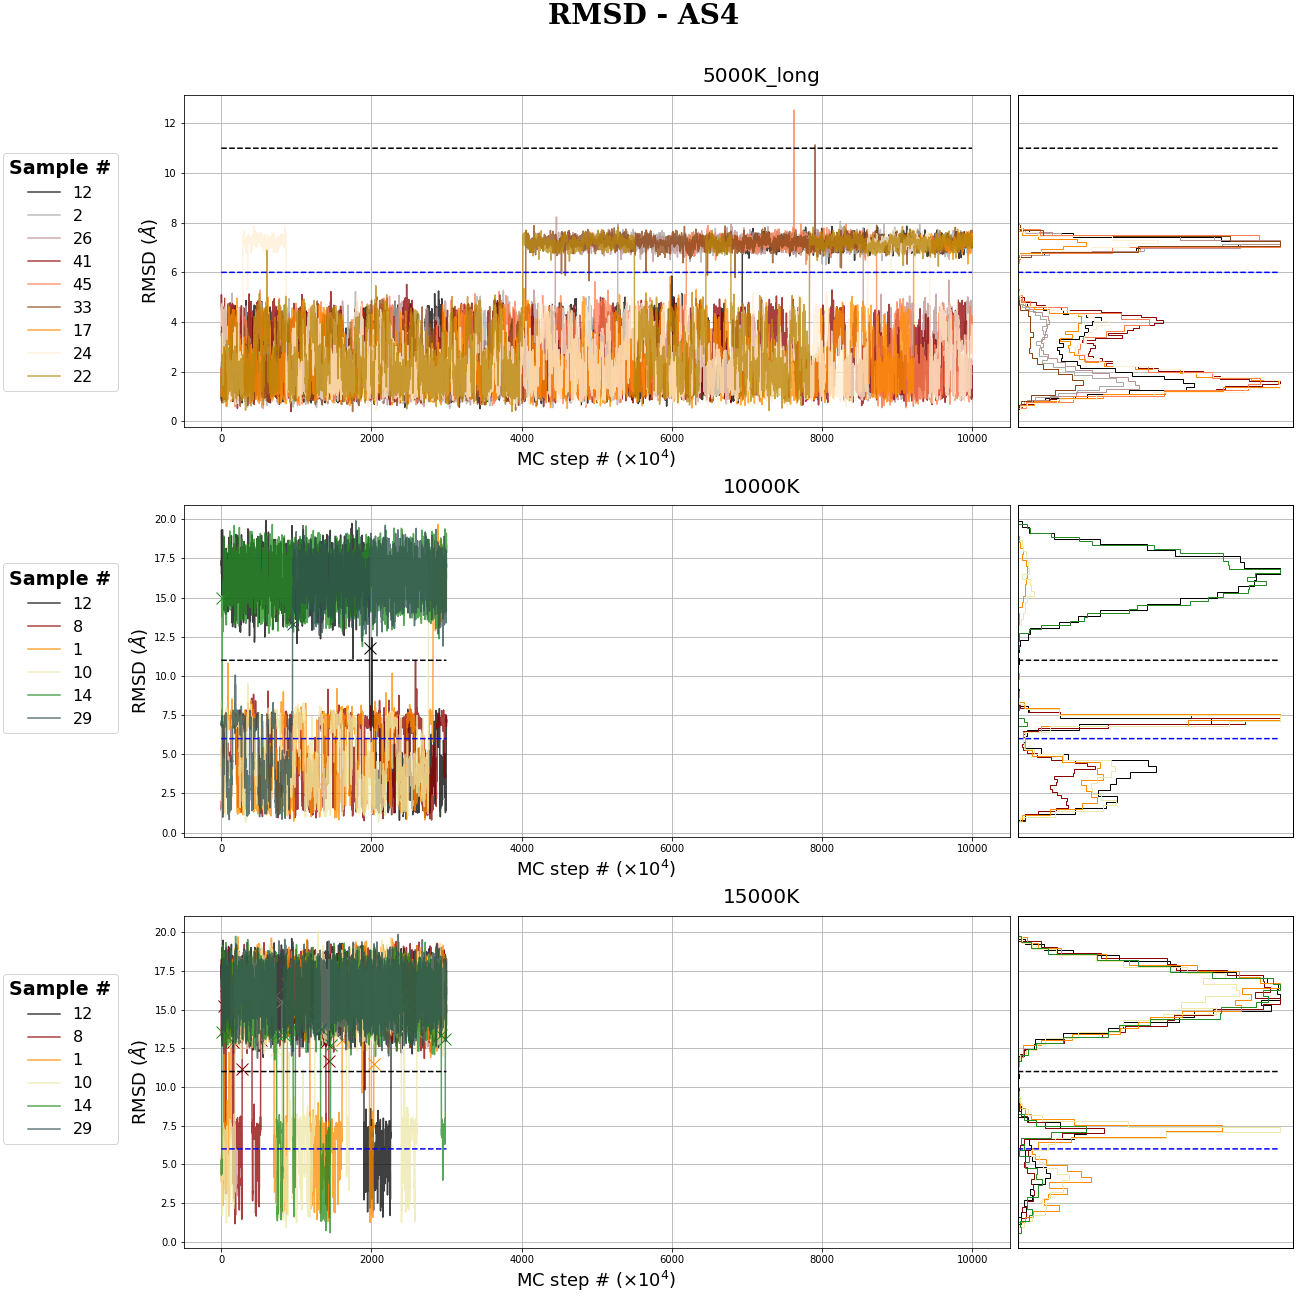

In [199]:
#@title AS4-MR
fig, data_MC_AS4, total_bindings_AS4 = Plot_RMSD('AS4', ['5000K_long', '10000K', '15000K'], N_plot=6)

In [200]:
print(data_MC_AS4.head())
print(' ')
print(total_bindings_AS4)

  ligand temperature sample  j index type heights  binding  unbinding
0    AS4  5000K_long     12  0    []   []      []        0          0
1    AS4  5000K_long     30  1    []   []      []        0          0
2    AS4  5000K_long     49  2    []   []      []        0          0
3    AS4  5000K_long     28  3    []   []      []        0          0
4    AS4  5000K_long     16  4    []   []      []        0          0
 
  ligand temperature  binding  unbinding
0    AS4  5000K_long        1          0
1    AS4      10000K       23          5
2    AS4      15000K      100         85


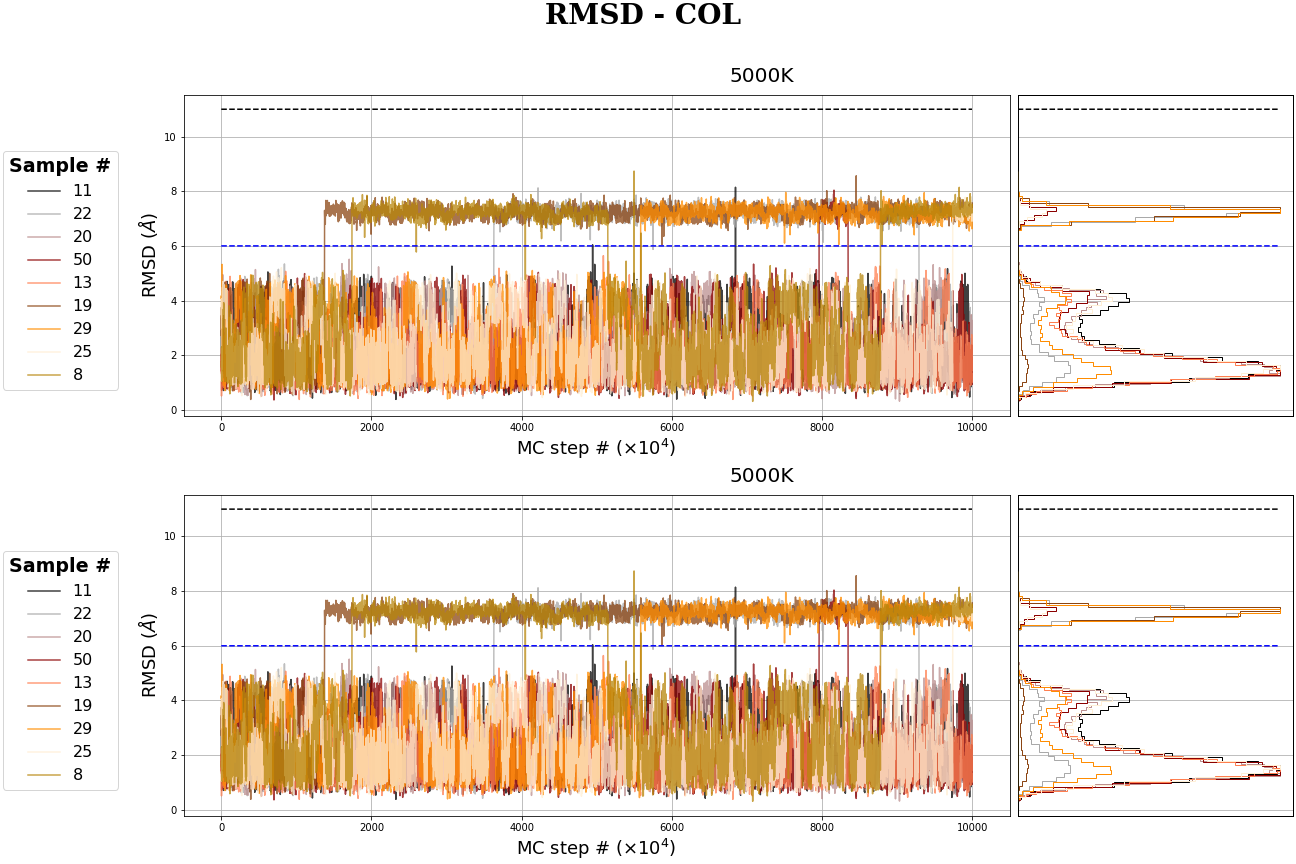

In [201]:
#@title COL
fig, data_MC_COL, total_bindings_COL = Plot_RMSD('COL', ['5000K', '5000K'], N_plot=6)

In [202]:
print(data_MC_COL.head())
print(' ')
print(total_bindings_COL)

  ligand temperature sample  j index type heights  binding  unbinding
0    COL       5000K     11  0    []   []      []        0          0
1    COL       5000K     23  1    []   []      []        0          0
2    COL       5000K     39  2    []   []      []        0          0
3    COL       5000K     37  3    []   []      []        0          0
4    COL       5000K     42  4    []   []      []        0          0
 
  ligand temperature  binding  unbinding
0    COL       5000K        0          0


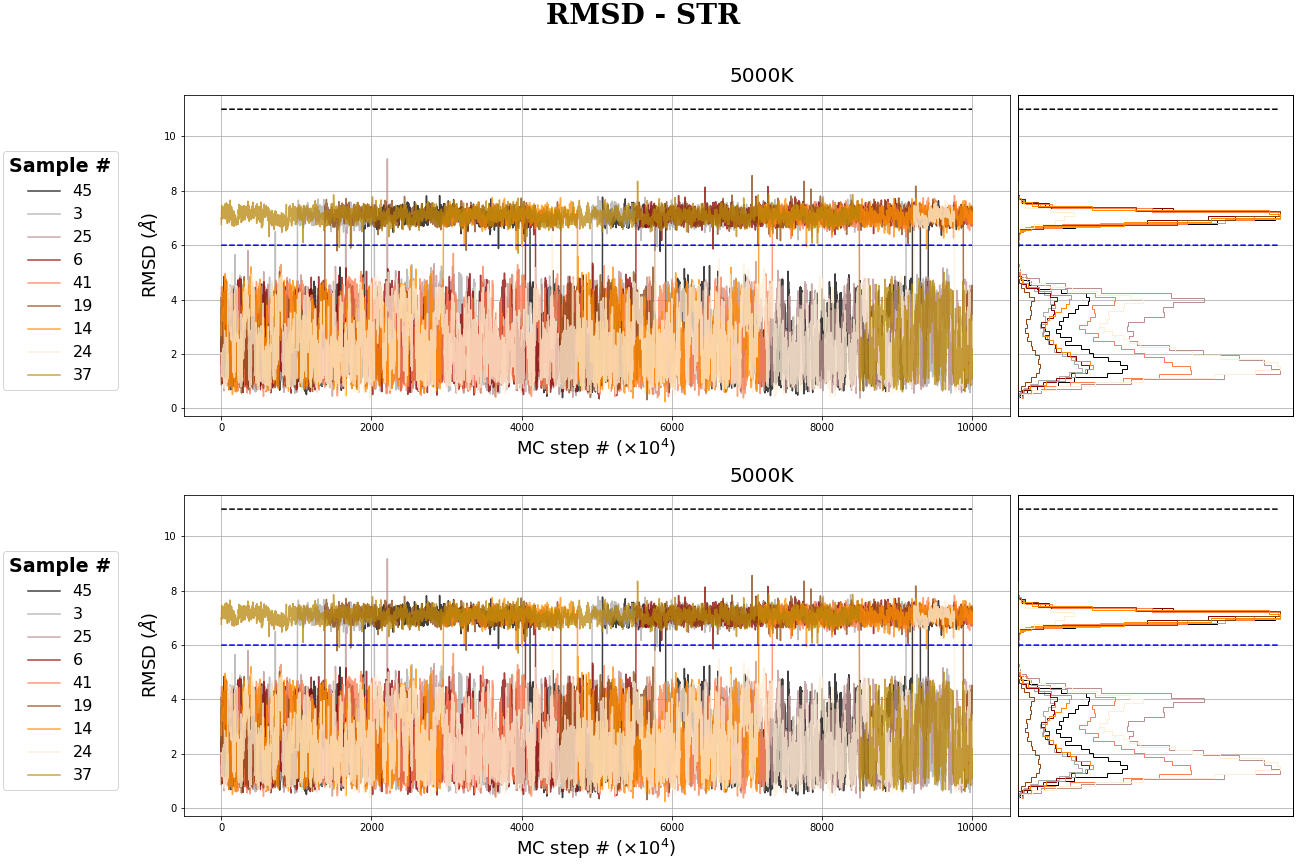

In [203]:
#@title STR
fig, data_MC_STR, total_bindings_STR = Plot_RMSD('STR', ['5000K', '5000K'], N_plot=6)

In [204]:
print(data_MC_STR.head())
print(' ')
print(total_bindings_STR)

  ligand temperature sample  j index type heights  binding  unbinding
0    STR       5000K     45  0    []   []      []        0          0
1    STR       5000K     11  1    []   []      []        0          0
2    STR       5000K     15  2    []   []      []        0          0
3    STR       5000K     42  3    []   []      []        0          0
4    STR       5000K     40  4    []   []      []        0          0
 
  ligand temperature  binding  unbinding
0    STR       5000K        0          0


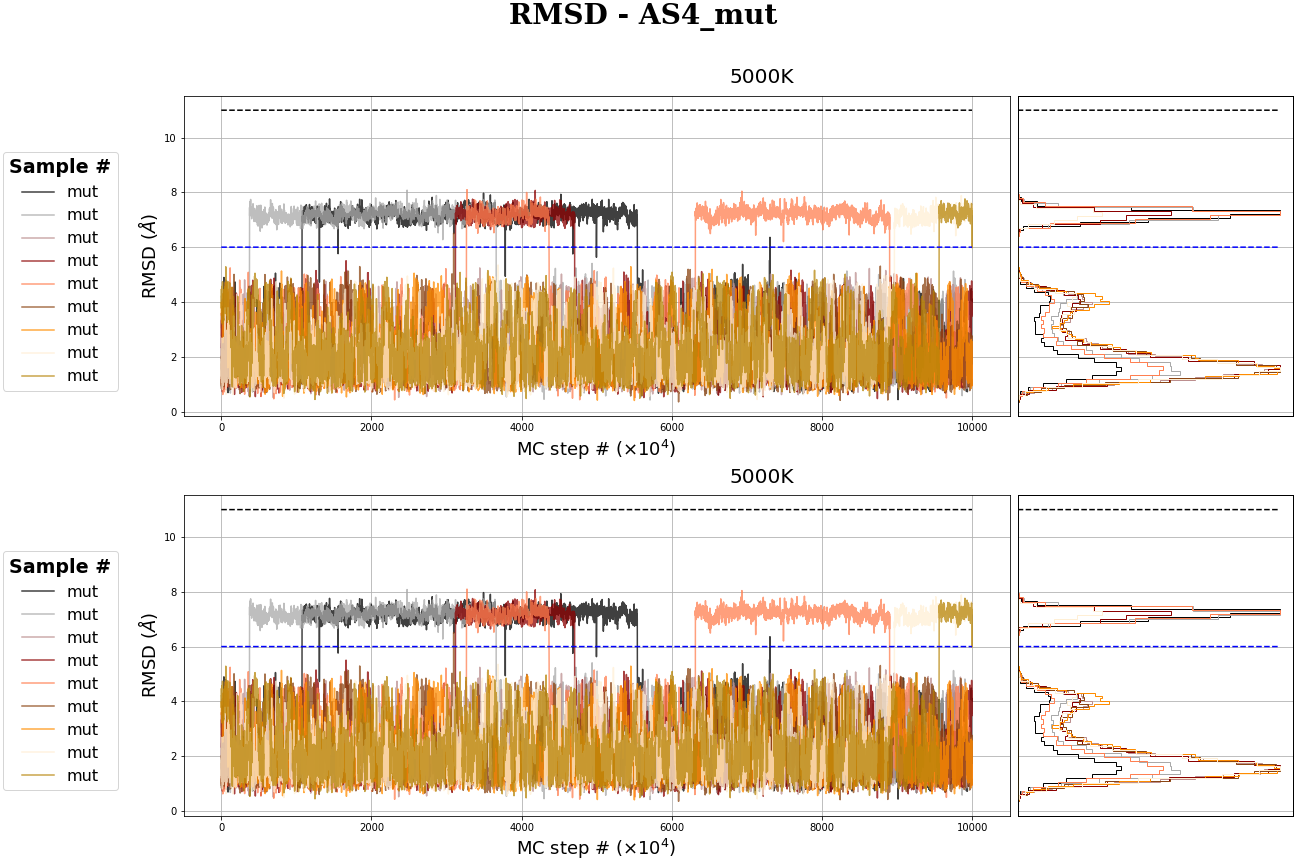

In [205]:
#@title AS4_mut
fig, data_MC_AS4_mut, total_bindings_AS4_mut = Plot_RMSD('AS4_mut', ['5000K', '5000K'], N_plot=6)

In [206]:
print(data_MC_AS4_mut.head())
print(' ')
print(total_bindings_AS4_mut)

    ligand temperature sample  j index type heights  binding  unbinding
0  AS4_mut       5000K    mut  0    []   []      []        0          0
1  AS4_mut       5000K    mut  1    []   []      []        0          0
2  AS4_mut       5000K    mut  2    []   []      []        0          0
3  AS4_mut       5000K    mut  3    []   []      []        0          0
4  AS4_mut       5000K    mut  4    []   []      []        0          0
 
    ligand temperature  binding  unbinding
0  AS4_mut       5000K        6          0


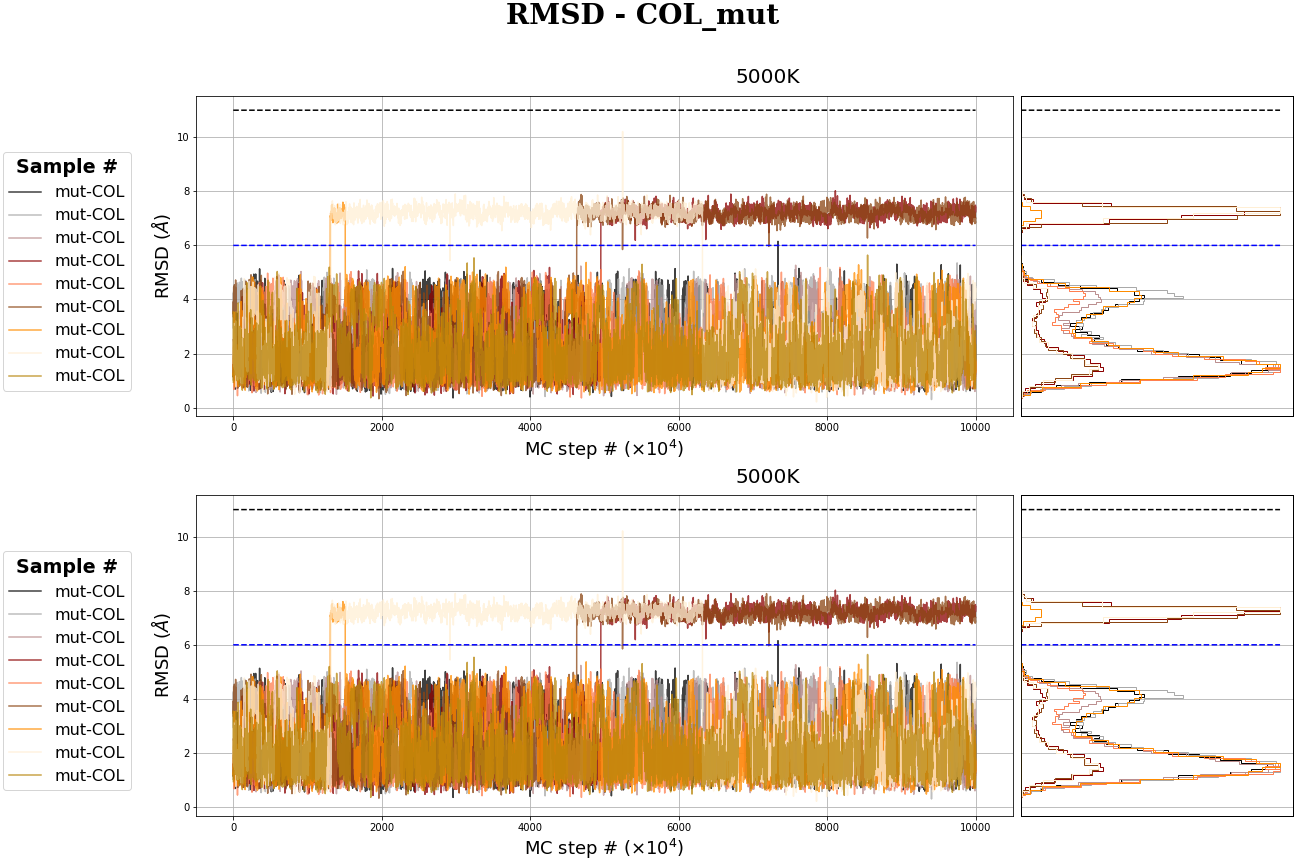

In [207]:
#@title COL_mut
fig, data_MC_COL_mut, total_bindings_COL_mut = Plot_RMSD('COL_mut', ['5000K', '5000K'], N_plot=6)

In [208]:
print(data_MC_COL_mut.head())
print(' ')
print(total_bindings_COL_mut)

    ligand temperature   sample  j   index       type  heights  binding  \
0  COL_mut       5000K  mut-COL  0      []         []       []        0   
1  COL_mut       5000K  mut-COL  1      []         []       []        0   
2  COL_mut       5000K  mut-COL  2      []         []       []        0   
3  COL_mut       5000K  mut-COL  3  [4062]  [binding]  [12.99]        1   
4  COL_mut       5000K  mut-COL  4      []         []       []        0   

   unbinding  
0          0  
1          0  
2          0  
3          0  
4          0  
 
    ligand temperature  binding  unbinding
0  COL_mut       5000K        6          0


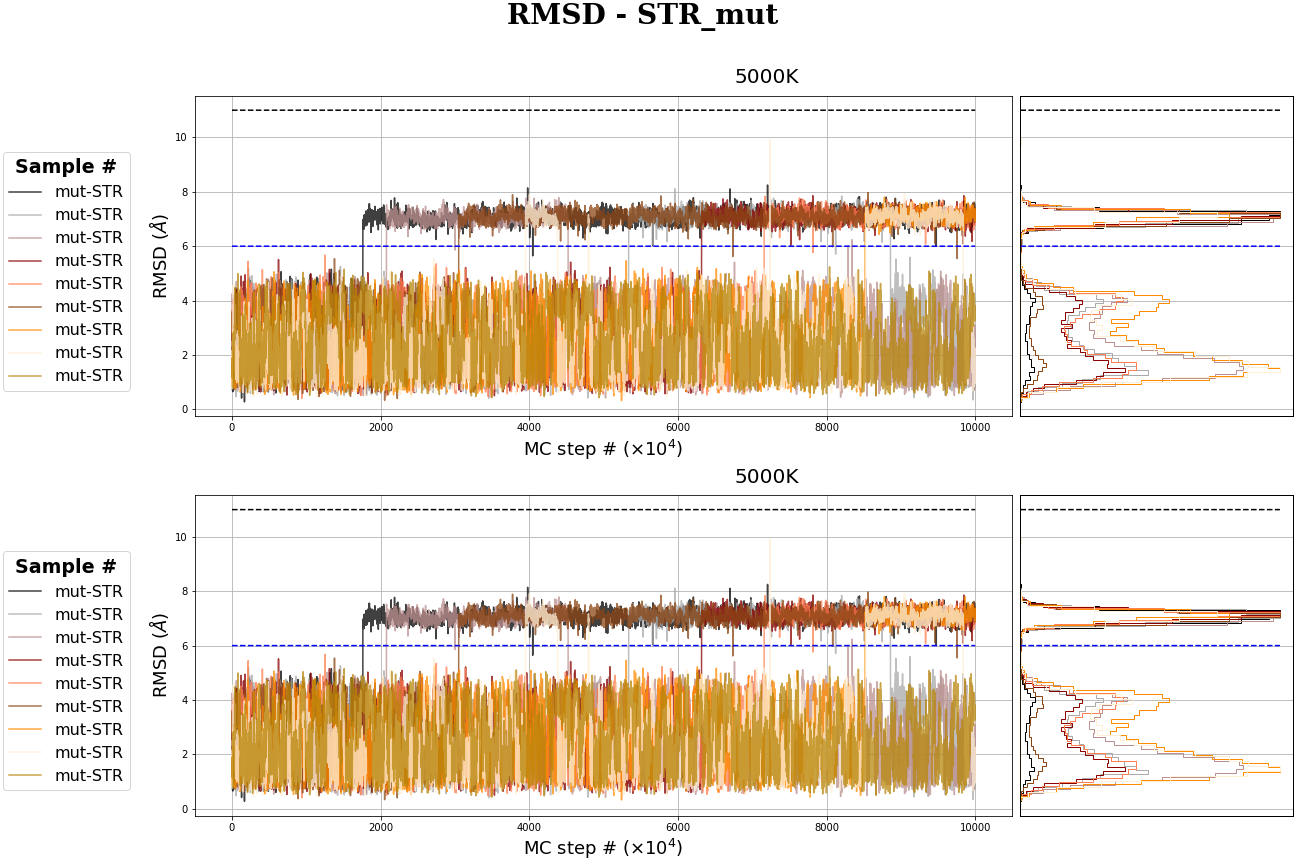

In [209]:
#@title STR_mut
fig, data_MC_STR_mut, total_bindings_STR_mut = Plot_RMSD('STR_mut', ['5000K', '5000K'], N_plot=6)

In [210]:
print(data_MC_STR_mut.head())
print(' ')
print(total_bindings_STR_mut)

    ligand temperature   sample  j index type heights  binding  unbinding
0  STR_mut       5000K  mut-STR  0    []   []      []        0          0
1  STR_mut       5000K  mut-STR  1    []   []      []        0          0
2  STR_mut       5000K  mut-STR  2    []   []      []        0          0
3  STR_mut       5000K  mut-STR  3    []   []      []        0          0
4  STR_mut       5000K  mut-STR  4    []   []      []        0          0
 
    ligand temperature  binding  unbinding
0  STR_mut       5000K        0          0


In [212]:
total_bindings = pd.concat([total_bindings_AS4,     total_bindings_COL,     total_bindings_STR,
                            total_bindings_AS4_mut, total_bindings_COL_mut, total_bindings_STR_mut], ignore_index=True)
total_bindings

ligand temperature  binding  unbinding
0      AS4  5000K_long        1          0
1      AS4      10000K       23          5
2      AS4      15000K      100         85
3      COL       5000K        0          0
4      STR       5000K        0          0
5  AS4_mut       5000K        6          0
6  COL_mut       5000K        6          0
7  STR_mut       5000K        0          0

In [213]:
data_MC = pd.concat([data_MC_AS4, data_MC_COL, data_MC_STR, data_MC_AS4_mut, data_MC_COL_mut, data_MC_STR_mut], ignore_index=True)
data_MC

ligand temperature   sample   j index type heights  binding  unbinding
0        AS4  5000K_long       12   0    []   []      []        0          0
1        AS4  5000K_long       30   1    []   []      []        0          0
2        AS4  5000K_long       49   2    []   []      []        0          0
3        AS4  5000K_long       28   3    []   []      []        0          0
4        AS4  5000K_long       16   4    []   []      []        0          0
..       ...         ...      ...  ..   ...  ...     ...      ...        ...
618  STR_mut       5000K  mut-STR  46    []   []      []        0          0
619  STR_mut       5000K  mut-STR  47    []   []      []        0          0
620  STR_mut       5000K  mut-STR  48    []   []      []        0          0
621  STR_mut       5000K  mut-STR  49    []   []      []        0          0
622  STR_mut       5000K  mut-STR  50    []   []      []        0          0

[623 rows x 9 columns]